In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.constants as const
from astropy.wcs import WCS
from matplotlib.patches import Ellipse
from astropy.coordinates import SkyCoord

from tqdm import tqdm


from astropy import units as u

# Initial data

In [2]:
from casatasks import tclean, exportfits, immoments

In [3]:
path_to_data = '../data/Workable/'
path_to_output = '../output/cleaned/'
name_of_obss = 'Glass-z13_target_concat_tbin30s_cwidth38MHz_60spw_contsub.ms'
# name_of_obss = 'Glass-z13_target_concat_tbin30s_cwidth38MHz_60spw.ms'
# name_of_obss = 'Glass-z13_target_concat_tbin30s_cwidth38MHz_JWST.ms'

outfile = path_to_output + name_of_obss

# tclean(vis         = path_to_data + name_of_obss,
#        imagename   = outfile.replace('.ms', 'line.im'),
#        specmode    = 'cube',
#        deconvolver = 'hogbom',
#        gridder     = 'standard',
#        imsize      = [512,512],
#        cell        = ['0.05arcsec'],
#        reffreq     = '254.35GHz',
#        weighting   = 'natural',
#        niter       = 0,
#        interactive = False,
#        )

# exportfits(imagename   = outfile.replace('.ms', 'line.im.image'),
#            fitsimage   = outfile.replace('.ms', 'line.im.fits'),
#            overwrite   = True
#           )

In [4]:
fname = outfile.replace('.ms', 'line.im.fits')
hdu = fits.open(outfile.replace('.ms', 'line.im.fits'))
cube = hdu[0].data[0]

In [5]:
freqs = np.arange(len(cube))*hdu[0].header['CDELT3'] + hdu[0].header['CRVAL3']
velos = (freqs-254.35e9)/254.35e9*const.c.to(u.km/u.s).value

index = np.argmin(np.abs(velos))
moment0 = np.sum(cube[index-8:index+8], axis = 0)

# Image Data

## Moment-0

In [27]:
def plot_fits_image_with_wcs(fits_file, box_size_arcsec, center_coord, index):
    """
    Plots a FITS file image with WCS coordinates for the axes in RA and DEC.
    Allows zooming in to a specified box size in arcseconds centered on a given coordinate.

    Parameters:
    fits_file (str): Path to the FITS file.
    box_size_arcsec (float): Size of the box to display in arcseconds.
    center_coord (tuple): (RA, DEC) coordinates to center the zoom-in region.
    """
    # Open the FITS file
    with fits.open(fits_file) as hdul:
        # Get the data from the first HDU
        data = hdul[0].data
        data = np.sum(data[0,index[0]:index[1]], axis=0)*1e3
        
        # Get the WCS information from the header
        wcs = WCS(hdul[0].header, naxis = 2)
        
        beam_major = np.average(hdu[1].data['BMAJ'])  # arcseconds
        beam_minor = np.average(hdu[1].data['BMIN'])  # arcseconds
        beam_pa = np.average(hdu[1].data['BPA'])  # Position angle in degrees

    
    # Convert the center coordinates from (RA, DEC) to pixel values
    center_x, center_y = wcs.world_to_pixel_values(center_coord[0], center_coord[1])
    
    # Convert box size from arcseconds to pixels
    pix_scale_x = np.abs(wcs.wcs.cdelt[0]) * 3600  # arcsec per pixel in x direction
    pix_scale_y = np.abs(wcs.wcs.cdelt[1]) * 3600  # arcsec per pixel in y direction
    
    box_size_x_pix = box_size_arcsec / pix_scale_x
    box_size_y_pix = box_size_arcsec / pix_scale_y
    
    # Determine the bounding box in pixel coordinates
    x_min = int(center_x - box_size_x_pix / 2)
    x_max = int(center_x + box_size_x_pix / 2)
    y_min = int(center_y - box_size_y_pix / 2)
    y_max = int(center_y + box_size_y_pix / 2)
    
    # Estimate the standard deviation outside the bounding box
    mask = np.ones(data.shape, dtype=bool)
    mask[y_min:y_max, x_min:x_max] = False
    std_dev = np.nanstd(data[mask])

    # Crop the data to the bounding box
    cropped_data = data[y_min:y_max, x_min:x_max]

    # Adjust WCS for the cropped image
    cropped_wcs = wcs[y_min:y_max, x_min:x_max]

    # Plot the cropped image with WCS projection
    fig, ax = plt.subplots(subplot_kw={'projection': cropped_wcs}, figsize=(10,8))
    im = ax.imshow(data[y_min:y_max, x_min:x_max], origin='lower', cmap='RdBu_r', vmin = np.nanmin(data), vmax = -1*np.nanmin(data))
    ax.set_xlabel('RA (J2000)')
    ax.set_ylabel('DEC (J2000)')
    
    # Plot contours based on the estimated standard deviation
    levels = [-3*std_dev, -2*std_dev,-1*std_dev, std_dev, 2*std_dev, 3*std_dev]  # Example contour levels
    ax.contour(cropped_data, levels=levels, colors='k', alpha=0.7)
    
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical')
    cbar.set_label(r'$S_{\nu}$ [mJy/Beam km/s]')

    # Plot the beam size in the lower right corner
    beam_major_pix = beam_major / pix_scale_x
    beam_minor_pix = beam_minor / pix_scale_y    
    beam = Ellipse((10, 10), width=beam_minor_pix, height=beam_major_pix,
                   angle=beam_pa, color='gray', fill='//')
    ax.add_patch(beam)
    
    # Plot a cross at the center coordinates
    c = SkyCoord(center_coord[0], center_coord[1], frame='icrs', unit='deg')
    center_x, center_y = cropped_wcs.world_to_pixel(c)
    
    ax.scatter(center_x, center_y, color='goldenrod', marker ='x', s = 100)
    # ax.scatter(center_coord[0], center_coord[1], color='goldenrod', marker ='x')
    plt.show()

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


255.99999645753638 255.9960011195755


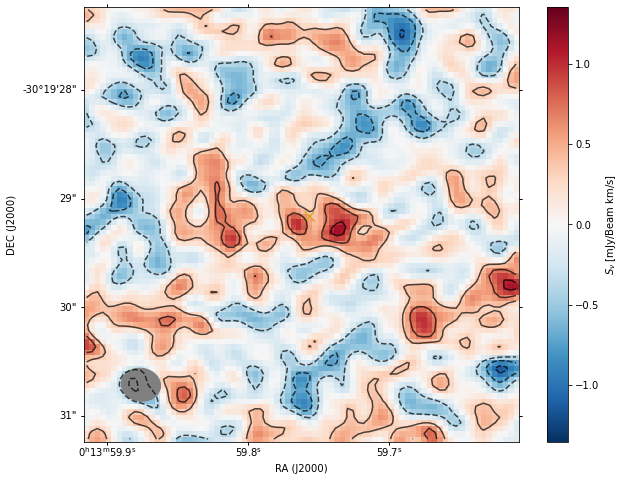

In [7]:
fname = '../output/cleaned/Glass-z13_target_concat_tbin30s_cwidth38MHz_60spw_contsubline.im.fits'
plot_fits_image_with_wcs(fname, 4, (3.498985, -30.324767), (index-5, index+5))  # Replace with your FITS file path, desired box size in arcseconds, and center coordinates (RA, DEC)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


255.99999645753638 255.9960011195755


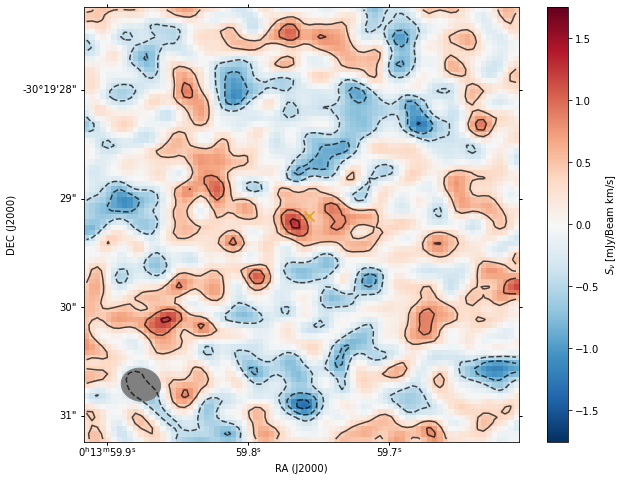

In [8]:
fname = '../output/cleaned/Glass-z13_target_concat_tbin30s_cwidth38MHz_60spwline.im.fits'
plot_fits_image_with_wcs(fname, 4, (3.498985, -30.324767),  (index-5, index+5))  # Replace with your FITS file path, desired box size in arcseconds, and center coordinates (RA, DEC)

## SLP

In [9]:
class SLP():
    """
    A class that manages cleaned data cubes and estiamtes the spectral line profile of that cube given a mask to sum over
    Input:
        cube (channel, image, image): Cleaned data in units of Jy/pixel
        mask (image, image): A mask that matches the size of the image. The mask is used to some over the pixels.
    Output (with function execute):
        slp (len(channels)): Intensity, units of Jy.
        bootstrap_std: bootstrapped std in units of Jy. 
    
    """
    
    def __init__(self, cube, mask, amount = 200, visualize = False):
        self.visualize = visualize
        self.cube   = cube
        self.mask   = mask
        self.amount = amount
        
        xx, yy         = np.meshgrid(np.arange(0,self.cube.shape[-2], 1), np.arange(0, self.cube.shape[-1],1))
        self.CoM_mask  =  (np.mean(xx[self.mask]), np.mean(yy[self.mask]))
        self.rr        = ((xx-self.CoM_mask[0])**2 + (yy-self.CoM_mask[1])**2)**0.5
        
        self.mask_size = int(np.sum(self.mask)**0.5+0.1*self.cube.shape[-2]) # --> quick fix

    def _position(self):

        r =  np.sqrt(np.random.uniform(0.1,1, size = self.amount))
        theta = np.random.uniform(0,1, size = self.amount) * 2 * np.pi

        x = self.CoM_mask[0] + self.cube.shape[1]/3 *r* np.cos(theta) #hard coded
        y = self.CoM_mask[1] + self.cube.shape[1]/3 *r* np.sin(theta) #hard coded
        
        pos = np.array([x,y], dtype = np.int).T
        return np.vstack(([int(self.CoM_mask[0]), int(self.CoM_mask[1])], pos))

    def _make_mask(self, pos):
        new_masks = np.zeros((len(pos[1:]),self.im.shape[-2], self.im.shape[-1]))
        for idx, xy in enumerate(pos[1:]):
            new_masks[idx, 
                      xy[0]-self.mask_size//2:xy[0]+self.mask_size//2, 
                      xy[1]-self.mask_size//2:xy[1]+self.mask_size//2] = self.mask[pos[0][0]-self.mask_size//2:pos[0][0]+self.mask_size//2, 
                                                                                   pos[0][1]-self.mask_size//2:pos[0][1]+self.mask_size//2]
            
            
        return new_masks.astype(bool)  
    
    def _estimates(self, new_masks):
        estimates = []
        for m in new_masks:
            estimates.append(np.sum(self.im[m]))
        return np.nanstd(estimates), np.nanmean(estimates)
    
    def _visualize(self, masks):
        for idx, m in enumerate(masks):
            clear_output(True)
            plt.imshow(m, origin='lower')
            plt.show()
            if idx>30: break
    
    def execute(self):

        bootstrap_std = []
        bootstrap_means = []
        for i in tqdm(range(len(self.cube))):
            self.im = self.cube[i]
            pos     = self._position()
            masks   = self._make_mask(pos)            

            std, mean = self._estimates(masks)
            bootstrap_std.append(std)
            bootstrap_means.append(mean)
            
        if self.visualize: self._visualize(masks)

        return np.array(bootstrap_std), np.array(bootstrap_means)

In [10]:
def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))

def ellipsoid_mask(im, xc, yc, a, b, Theta):
    ny, nx = im.shape
    y,x = np.mgrid[0:nx,0:ny]
    e = (((x-xc) * np.cos(Theta) + (y - yc)*np.sin(Theta))**2)/a**2 +  (((x-xc) * np.sin(Theta) - (y - yc)*np.cos(Theta))**2)/b**2
    return (e<=1)

In [11]:
# fname = '../output/cleaned/Glass-z13_target_concat_tbin30s_cwidth38MHz_60spwline.im.fits'

# # Load in Cube
# # ------------
# cube, header = fits.getdata(fname, header = True)

# BMAJ = np.average(hdu[1].data['BMAJ'])/3600  # degrees
# BMIN = np.average(hdu[1].data['BMIN'])/3600  # degrees
# BPA = np.average(hdu[1].data['BPA'])  # Position angle in degrees

# pixel_size = header['CDELT1']
# Dfreq    = header['CDELT3']
# restfreq = header['CRVAL3']

# BeamArea     = np.pi *BMIN*BMAJ/pixel_size**2/(4*np.log(2))   # pixels per beam 
# cube         = cube[0]/BeamArea*1e3                           # mJy/pixel

# mask = ellipsoid_mask(cube[0], 
#                       len(cube[0])//2, 
#                       len(cube[0])//2, 
#                       BMIN/pixel_size, 
#                       BMAJ/pixel_size, 
#                       np.deg2rad(BPA))


# xaxis      = (np.arange(len(cube))*Dfreq + restfreq)/1e9    
# slp        = np.nansum(cube[:, mask], axis = 1)
# normal_std = np.nanstd(cube[:,~mask], axis = 1) * np.sqrt(np.sum(mask))
# mask = ellipsoid_mask(cube[0], 
#                       len(cube[0])//2, 
#                       len(cube[0])//2, 
#                       BMIN/pixel_size, 
#                       BMAJ/pixel_size, 
#                       np.deg2rad(BPA))

# obj                           = SLP(cube, mask, amount = 1000, visualize=False)
# bootstrap_std, bootstrap_mean = obj.execute()

# # Visualize SLP
# # -----------------
# fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [2, 1]})

# ax[0].step(xaxis, slp/bootstrap_std, label = 'Central Beam', c = 'C0')
# ax[0].axhline(0, c='gray', ls='--')
# ax[0].set_xlim(xmin = xaxis[0], xmax = xaxis[-1])
# ax[0].set_ylim(ymin =-2.5, ymax = 3.5)
# ax[0].set_ylabel('SNR')
# ax[0].legend(loc = 1, frameon=False)
# ax[0].axvline(254.35, c = 'k')

# # ax[1].step(xaxis, normal_std, label='conventional image')
# ax[1].step(xaxis, bootstrap_std, label='bootstrap', c = 'C1')
# ax[1].axhline(np.nanstd(slp), label='std spectral', c='k', alpha = 0.6)    

# ax[1].set_xlim(xmin = xaxis[0], xmax = xaxis[-1])
# ax[1].set_ylim(ymin = 0.15, ymax = 0.25)
# ax[1].set_xlabel('Freq [GHz]')
# ax[1].set_ylabel('mJy')
# ax[1].legend(loc = 1, frameon=False)

# plt.tight_layout()
# plt.show()

In [12]:
# fname = '../output/cleaned/Glass-z13_target_concat_tbin30s_cwidth38MHz_60spw_contsubline.im.fits'

# # Load in Cube
# # ------------
# cube, header = fits.getdata(fname, header = True)

# BMAJ = np.average(hdu[1].data['BMAJ'])/3600  # degrees
# BMIN = np.average(hdu[1].data['BMIN'])/3600  # degrees
# BPA = np.average(hdu[1].data['BPA'])  # Position angle in degrees

# pixel_size = header['CDELT1']
# Dfreq    = header['CDELT3']
# restfreq = header['CRVAL3']

# BeamArea     = np.pi *BMIN*BMAJ/pixel_size**2/(4*np.log(2))   # pixels per beam 
# cube         = cube[0]/BeamArea*1e3                           # mJy/pixel

# mask = ellipsoid_mask(cube[0], 
#                       len(cube[0])//2, 
#                       len(cube[0])//2, 
#                       BMIN/pixel_size, 
#                       BMAJ/pixel_size, 
#                       np.deg2rad(BPA))


# xaxis      = (np.arange(len(cube))*Dfreq + restfreq)/1e9    
# slp        = np.nansum(cube[:, mask], axis = 1)
# normal_std = np.nanstd(cube[:,~mask], axis = 1) * np.sqrt(np.sum(mask))
# mask = ellipsoid_mask(cube[0], 
#                       len(cube[0])//2, 
#                       len(cube[0])//2, 
#                       BMIN/pixel_size, 
#                       BMAJ/pixel_size, 
#                       np.deg2rad(BPA))

# obj                           = SLP(cube, mask, amount = 1000, visualize=False)
# bootstrap_std, bootstrap_mean = obj.execute()

# # Visualize SLP
# # -----------------
# fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [2, 1]})

# ax[0].step(xaxis, slp/bootstrap_std, label = 'Central Beam', c = 'C0')
# ax[0].axhline(0, c='gray', ls='--')
# ax[0].set_xlim(xmin = xaxis[0], xmax = xaxis[-1])
# ax[0].set_ylim(ymin =-2.5, ymax = 3.5)
# ax[0].set_ylabel('SNR')
# ax[0].legend(loc = 1, frameon=False)
# ax[0].axvline(254.35, c = 'k')

# # ax[1].step(xaxis, normal_std, label='conventional image')
# ax[1].step(xaxis, bootstrap_std, label='bootstrap', c = 'C1')
# ax[1].axhline(np.nanstd(slp), label='std spectral', c='k', alpha = 0.6)    

# ax[1].set_xlim(xmin = xaxis[0], xmax = xaxis[-1])
# ax[1].set_ylim(ymin = 0.15, ymax = 0.25)
# ax[1].set_xlabel('Freq [GHz]')
# ax[1].set_ylabel('mJy')
# ax[1].legend(loc = 1, frameon=False)

# plt.tight_layout()
# plt.show()

# Line Finder

# Jack knife

In [25]:
import sys
sys.path.insert(1, '../Jack-knife/src/')
import os
from IPython.display import clear_output
import jacked

In [14]:
#which observations do you want to corrupt
VIS        = '/lustre/home/jvmarrewijk/JWST_candidates/data/Workable/Glass-z13_target_concat_tbin30s_cwidth38MHz_60spw.ms'
 
FIELDS     = ['3']
SPWS       = [['0']]
BAND       = 'Band7'
ARRAY      = 'C7'

#how many new samples do you need
N          = 300

  0%|          | 0/300 [00:00<?, ?it/s]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  0%|          | 1/300 [02:26<12:12:02, 146.90s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  1%|          | 2/300 [05:02<12:35:04, 152.03s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  1%|          | 3/300 [07:31<12:26:13, 150.75s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  1%|▏         | 4/300 [10:03<12:25:33, 151.13s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  2%|▏         | 5/300 [12:38<12:29:22, 152.42s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  2%|▏         | 6/300 [15:07<12:22:01, 151.43s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  2%|▏         | 7/300 [17:37<12:16:42, 150.86s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  3%|▎         | 8/300 [20:09<12:16:25, 151.32s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  3%|▎         | 9/300 [22:48<12:25:50, 153.78s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  3%|▎         | 10/300 [25:10<12:04:47, 149.96s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  4%|▎         | 11/300 [27:41<12:03:52, 150.28s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  4%|▍         | 12/300 [30:10<11:59:10, 149.83s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  4%|▍         | 13/300 [32:43<12:02:01, 150.95s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  5%|▍         | 14/300 [35:10<11:53:49, 149.75s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  5%|▌         | 15/300 [37:33<11:41:07, 147.60s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  5%|▌         | 16/300 [40:09<11:50:21, 150.08s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  6%|▌         | 17/300 [42:32<11:38:24, 148.07s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  6%|▌         | 18/300 [44:57<11:32:15, 147.29s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  6%|▋         | 19/300 [47:20<11:22:59, 145.84s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  7%|▋         | 20/300 [49:45<11:19:39, 145.64s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  7%|▋         | 21/300 [52:20<11:30:32, 148.50s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  7%|▋         | 22/300 [54:58<11:41:02, 151.30s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  8%|▊         | 23/300 [57:27<11:34:56, 150.53s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  8%|▊         | 24/300 [59:58<11:33:57, 150.86s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  8%|▊         | 25/300 [1:02:33<11:36:06, 151.88s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  9%|▊         | 26/300 [1:05:03<11:31:32, 151.43s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  9%|▉         | 27/300 [1:07:29<11:22:06, 149.91s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


  9%|▉         | 28/300 [1:10:01<11:21:51, 150.41s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 10%|▉         | 29/300 [1:12:26<11:12:42, 148.94s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 10%|█         | 30/300 [1:14:59<11:14:26, 149.88s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 10%|█         | 31/300 [1:17:38<11:24:50, 152.75s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 11%|█         | 32/300 [1:20:08<11:18:43, 151.95s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 11%|█         | 33/300 [1:22:42<11:18:51, 152.55s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 11%|█▏        | 34/300 [1:25:19<11:22:34, 153.96s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 12%|█▏        | 35/300 [1:27:51<11:16:21, 153.14s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 12%|█▏        | 36/300 [1:30:18<11:06:25, 151.46s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 12%|█▏        | 37/300 [1:32:58<11:15:13, 154.05s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 13%|█▎        | 38/300 [1:35:36<11:17:56, 155.25s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 13%|█▎        | 39/300 [1:38:07<11:10:02, 154.03s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 13%|█▎        | 40/300 [1:40:36<10:59:55, 152.29s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 14%|█▎        | 41/300 [1:43:02<10:49:57, 150.57s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 14%|█▍        | 42/300 [1:45:34<10:48:38, 150.85s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 14%|█▍        | 43/300 [1:48:13<10:56:54, 153.36s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 15%|█▍        | 44/300 [1:50:47<10:55:44, 153.69s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 15%|█▌        | 45/300 [1:53:16<10:46:11, 152.04s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 15%|█▌        | 46/300 [1:55:42<10:36:06, 150.26s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 16%|█▌        | 47/300 [1:58:10<10:31:24, 149.74s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 16%|█▌        | 48/300 [2:00:44<10:34:09, 150.99s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 16%|█▋        | 49/300 [2:03:11<10:26:00, 149.64s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 17%|█▋        | 50/300 [2:05:35<10:16:35, 147.98s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 17%|█▋        | 51/300 [2:08:07<10:19:14, 149.22s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 17%|█▋        | 52/300 [2:10:34<10:13:45, 148.49s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 18%|█▊        | 53/300 [2:13:00<10:08:32, 147.82s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 18%|█▊        | 54/300 [2:15:29<10:08:16, 148.36s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 18%|█▊        | 55/300 [2:17:56<10:03:53, 147.89s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 19%|█▊        | 56/300 [2:20:26<10:03:41, 148.45s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 19%|█▉        | 57/300 [2:22:53<9:59:16, 147.97s/it] 

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 19%|█▉        | 58/300 [2:25:17<9:52:36, 146.93s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 20%|█▉        | 59/300 [2:27:47<9:53:08, 147.67s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 20%|██        | 60/300 [2:30:09<9:43:49, 145.95s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 20%|██        | 61/300 [2:32:40<9:48:04, 147.64s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 21%|██        | 62/300 [2:35:16<9:55:03, 150.02s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 21%|██        | 63/300 [2:37:45<9:51:01, 149.63s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 21%|██▏       | 64/300 [2:40:07<9:40:14, 147.52s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 22%|██▏       | 65/300 [2:42:45<9:49:58, 150.63s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 22%|██▏       | 66/300 [2:45:14<9:46:02, 150.27s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 22%|██▏       | 67/300 [2:47:42<9:40:12, 149.41s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 23%|██▎       | 68/300 [2:50:07<9:32:56, 148.17s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 23%|██▎       | 69/300 [2:52:32<9:26:41, 147.19s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 23%|██▎       | 70/300 [2:55:02<9:27:21, 148.01s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 24%|██▎       | 71/300 [2:57:28<9:22:03, 147.26s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 24%|██▍       | 72/300 [3:00:00<9:25:30, 148.82s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 24%|██▍       | 73/300 [3:02:33<9:28:03, 150.15s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 25%|██▍       | 74/300 [3:04:59<9:20:08, 148.71s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 25%|██▌       | 75/300 [3:07:27<9:17:12, 148.59s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 25%|██▌       | 76/300 [3:09:52<9:10:28, 147.45s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 26%|██▌       | 77/300 [3:12:23<9:12:16, 148.59s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 26%|██▌       | 78/300 [3:14:45<9:03:00, 146.76s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 26%|██▋       | 79/300 [3:17:07<8:54:23, 145.08s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 27%|██▋       | 80/300 [3:19:44<9:05:45, 148.84s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 27%|██▋       | 81/300 [3:22:24<9:14:47, 152.00s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 27%|██▋       | 82/300 [3:24:51<9:07:04, 150.57s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 28%|██▊       | 83/300 [3:27:38<9:22:47, 155.61s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 28%|██▊       | 84/300 [3:30:15<9:21:22, 155.94s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 28%|██▊       | 85/300 [3:32:56<9:24:16, 157.47s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 29%|██▊       | 86/300 [3:35:24<9:11:52, 154.73s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 29%|██▉       | 87/300 [3:37:58<9:08:44, 154.57s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 29%|██▉       | 88/300 [3:40:26<8:59:06, 152.58s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 30%|██▉       | 89/300 [3:42:54<8:51:49, 151.23s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 30%|███       | 90/300 [3:45:27<8:50:42, 151.63s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 30%|███       | 91/300 [3:47:57<8:46:35, 151.17s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 31%|███       | 92/300 [3:50:24<8:39:47, 149.94s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 31%|███       | 93/300 [3:52:50<8:33:08, 148.73s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 31%|███▏      | 94/300 [3:55:20<8:32:17, 149.21s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 32%|███▏      | 95/300 [3:57:44<8:24:00, 147.52s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 32%|███▏      | 96/300 [4:00:14<8:24:00, 148.24s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 32%|███▏      | 97/300 [4:02:48<8:27:34, 150.02s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 33%|███▎      | 98/300 [4:05:22<8:29:06, 151.22s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 33%|███▎      | 99/300 [4:07:48<8:21:34, 149.72s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 33%|███▎      | 100/300 [4:10:17<8:17:40, 149.30s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 34%|███▎      | 101/300 [4:12:45<8:14:02, 148.96s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 34%|███▍      | 102/300 [4:15:21<8:19:03, 151.23s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 34%|███▍      | 103/300 [4:17:52<8:16:19, 151.16s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 35%|███▍      | 104/300 [4:20:19<8:09:49, 149.94s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 35%|███▌      | 105/300 [4:22:50<8:07:50, 150.11s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 35%|███▌      | 106/300 [4:25:18<8:03:26, 149.52s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 36%|███▌      | 107/300 [4:27:54<8:06:56, 151.38s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 36%|███▌      | 108/300 [4:30:25<8:04:34, 151.43s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 36%|███▋      | 109/300 [4:32:52<7:57:02, 149.86s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 37%|███▋      | 110/300 [4:35:14<7:47:20, 147.58s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 37%|███▋      | 111/300 [4:37:41<7:44:53, 147.58s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 37%|███▋      | 112/300 [4:40:06<7:39:08, 146.53s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 38%|███▊      | 113/300 [4:42:28<7:33:21, 145.46s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 38%|███▊      | 114/300 [4:45:03<7:39:21, 148.18s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 38%|███▊      | 115/300 [4:47:32<7:38:01, 148.55s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 39%|███▊      | 116/300 [4:50:02<7:36:21, 148.81s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 39%|███▉      | 117/300 [4:52:29<7:32:30, 148.37s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 39%|███▉      | 118/300 [4:54:56<7:28:52, 147.98s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 40%|███▉      | 119/300 [4:57:31<7:32:22, 149.96s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 40%|████      | 120/300 [5:00:02<7:31:10, 150.39s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 40%|████      | 121/300 [5:02:32<7:28:21, 150.29s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 41%|████      | 122/300 [5:04:55<7:19:25, 148.12s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 41%|████      | 123/300 [5:07:18<7:12:20, 146.56s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 41%|████▏     | 124/300 [5:09:49<7:13:19, 147.72s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 42%|████▏     | 125/300 [5:12:22<7:16:07, 149.53s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 42%|████▏     | 126/300 [5:14:54<7:15:14, 150.08s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 42%|████▏     | 127/300 [5:17:19<7:08:16, 148.53s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 43%|████▎     | 128/300 [5:19:49<7:07:41, 149.19s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 43%|████▎     | 129/300 [5:22:28<7:13:22, 152.06s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 43%|████▎     | 130/300 [5:24:50<7:02:07, 148.99s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 44%|████▎     | 131/300 [5:27:20<7:00:26, 149.27s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 44%|████▍     | 132/300 [5:29:52<7:00:15, 150.09s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 44%|████▍     | 133/300 [5:32:25<7:00:36, 151.12s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 45%|████▍     | 134/300 [5:35:04<7:04:21, 153.38s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 45%|████▌     | 135/300 [5:37:33<6:58:18, 152.11s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 45%|████▌     | 136/300 [5:39:58<6:49:47, 149.92s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 46%|████▌     | 137/300 [5:42:35<6:52:53, 151.98s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 46%|████▌     | 138/300 [5:45:10<6:52:56, 152.94s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 46%|████▋     | 139/300 [5:47:37<6:45:40, 151.19s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 47%|████▋     | 140/300 [5:50:07<6:42:27, 150.92s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 47%|████▋     | 141/300 [5:52:29<6:32:39, 148.17s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 47%|████▋     | 142/300 [5:54:59<6:31:38, 148.72s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 48%|████▊     | 143/300 [5:57:26<6:27:48, 148.21s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 48%|████▊     | 144/300 [5:59:59<6:29:15, 149.72s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 48%|████▊     | 145/300 [6:02:24<6:22:23, 148.02s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 49%|████▊     | 146/300 [6:04:53<6:20:39, 148.31s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 49%|████▉     | 147/300 [6:07:25<6:21:16, 149.52s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 49%|████▉     | 148/300 [6:09:47<6:12:55, 147.21s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 50%|████▉     | 149/300 [6:12:16<6:11:54, 147.78s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 50%|█████     | 150/300 [6:14:50<6:14:29, 149.80s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 50%|█████     | 151/300 [6:17:19<6:10:56, 149.38s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 51%|█████     | 152/300 [6:19:40<6:02:16, 146.87s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 51%|█████     | 153/300 [6:22:08<6:00:58, 147.34s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 51%|█████▏    | 154/300 [6:24:32<5:56:12, 146.39s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 52%|█████▏    | 155/300 [6:26:59<5:53:52, 146.43s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 52%|█████▏    | 156/300 [6:29:24<5:50:48, 146.17s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 52%|█████▏    | 157/300 [6:32:03<5:57:08, 149.85s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 53%|█████▎    | 158/300 [6:34:37<5:57:25, 151.02s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 53%|█████▎    | 159/300 [6:37:10<5:56:52, 151.86s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 53%|█████▎    | 160/300 [6:39:40<5:52:37, 151.12s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 54%|█████▎    | 161/300 [6:42:07<5:47:20, 149.93s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 54%|█████▍    | 162/300 [6:44:43<5:49:08, 151.80s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 54%|█████▍    | 163/300 [6:47:10<5:43:23, 150.39s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 55%|█████▍    | 164/300 [6:49:36<5:37:40, 148.97s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 55%|█████▌    | 165/300 [6:52:08<5:37:11, 149.86s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 55%|█████▌    | 166/300 [6:54:34<5:32:11, 148.74s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 56%|█████▌    | 167/300 [6:57:01<5:28:22, 148.14s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 56%|█████▌    | 168/300 [6:59:28<5:25:17, 147.86s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 56%|█████▋    | 169/300 [7:01:53<5:20:48, 146.93s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 57%|█████▋    | 170/300 [7:04:35<5:28:29, 151.61s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 57%|█████▋    | 171/300 [7:07:01<5:22:21, 149.93s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 57%|█████▋    | 172/300 [7:09:25<5:15:48, 148.04s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 58%|█████▊    | 173/300 [7:11:52<5:13:05, 147.92s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 58%|█████▊    | 174/300 [7:14:15<5:06:58, 146.17s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 58%|█████▊    | 175/300 [7:16:44<5:06:40, 147.20s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 59%|█████▊    | 176/300 [7:19:13<5:05:12, 147.68s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 59%|█████▉    | 177/300 [7:21:50<5:08:36, 150.54s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 59%|█████▉    | 178/300 [7:24:17<5:03:36, 149.32s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 60%|█████▉    | 179/300 [7:26:41<4:58:13, 147.88s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 60%|██████    | 180/300 [7:29:10<4:56:35, 148.30s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 60%|██████    | 181/300 [7:31:35<4:51:47, 147.12s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 61%|██████    | 182/300 [7:34:15<4:57:03, 151.05s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 61%|██████    | 183/300 [7:36:44<4:53:13, 150.38s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 61%|██████▏   | 184/300 [7:39:16<4:51:51, 150.97s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 62%|██████▏   | 185/300 [7:41:44<4:47:19, 149.90s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 62%|██████▏   | 186/300 [7:44:13<4:44:21, 149.66s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 62%|██████▏   | 187/300 [7:46:36<4:38:09, 147.69s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 63%|██████▎   | 188/300 [7:49:04<4:35:56, 147.83s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 63%|██████▎   | 189/300 [7:51:34<4:34:27, 148.35s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 63%|██████▎   | 190/300 [7:54:01<4:31:31, 148.10s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 64%|██████▎   | 191/300 [7:56:33<4:30:54, 149.12s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 64%|██████▍   | 192/300 [7:58:55<4:25:03, 147.26s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 64%|██████▍   | 193/300 [8:01:29<4:25:45, 149.02s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 65%|██████▍   | 194/300 [8:03:56<4:22:34, 148.63s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 65%|██████▌   | 195/300 [8:06:23<4:19:01, 148.02s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 65%|██████▌   | 196/300 [8:08:49<4:15:25, 147.36s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 66%|██████▌   | 197/300 [8:11:17<4:13:20, 147.58s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 66%|██████▌   | 198/300 [8:13:46<4:11:30, 147.94s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 66%|██████▋   | 199/300 [8:16:09<4:06:35, 146.49s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 67%|██████▋   | 200/300 [8:18:42<4:07:20, 148.41s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 67%|██████▋   | 201/300 [8:21:04<4:01:51, 146.58s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 67%|██████▋   | 202/300 [8:23:38<4:03:01, 148.79s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 68%|██████▊   | 203/300 [8:26:14<4:04:12, 151.06s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 68%|██████▊   | 204/300 [8:28:46<4:01:52, 151.18s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 68%|██████▊   | 205/300 [8:31:19<4:00:34, 151.94s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 69%|██████▊   | 206/300 [8:33:44<3:54:42, 149.81s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 69%|██████▉   | 207/300 [8:36:11<3:50:44, 148.87s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 69%|██████▉   | 208/300 [8:38:34<3:45:40, 147.18s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 70%|██████▉   | 209/300 [8:41:16<3:49:53, 151.57s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 70%|███████   | 210/300 [8:43:48<3:47:25, 151.62s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 70%|███████   | 211/300 [8:46:21<3:45:37, 152.11s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 71%|███████   | 212/300 [8:48:43<3:38:30, 148.98s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 71%|███████   | 213/300 [8:51:18<3:39:00, 151.04s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 71%|███████▏  | 214/300 [8:53:45<3:34:44, 149.83s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 72%|███████▏  | 215/300 [8:56:26<3:36:43, 152.98s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 72%|███████▏  | 216/300 [8:59:07<3:37:31, 155.38s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 72%|███████▏  | 217/300 [9:01:38<3:33:24, 154.27s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 73%|███████▎  | 218/300 [9:04:11<3:30:06, 153.74s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 73%|███████▎  | 219/300 [9:06:32<3:22:15, 149.83s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 73%|███████▎  | 220/300 [9:09:08<3:22:25, 151.82s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 74%|███████▎  | 221/300 [9:11:36<3:18:17, 150.60s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 74%|███████▍  | 222/300 [9:14:08<3:16:19, 151.03s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 74%|███████▍  | 223/300 [9:16:40<3:14:07, 151.26s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 75%|███████▍  | 224/300 [9:19:06<3:09:48, 149.85s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 75%|███████▌  | 225/300 [9:21:35<3:06:46, 149.43s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 75%|███████▌  | 226/300 [9:24:10<3:06:23, 151.13s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 76%|███████▌  | 227/300 [9:26:39<3:03:15, 150.62s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 76%|███████▌  | 228/300 [9:29:08<2:59:55, 149.94s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 76%|███████▋  | 229/300 [9:31:36<2:56:56, 149.52s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 77%|███████▋  | 230/300 [9:33:57<2:51:31, 147.02s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 77%|███████▋  | 231/300 [9:36:41<2:54:50, 152.04s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 77%|███████▋  | 232/300 [9:39:18<2:54:04, 153.60s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 78%|███████▊  | 233/300 [9:41:45<2:49:15, 151.57s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 78%|███████▊  | 234/300 [9:44:17<2:46:54, 151.73s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 78%|███████▊  | 235/300 [9:46:50<2:44:39, 151.99s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 79%|███████▊  | 236/300 [9:49:20<2:41:40, 151.57s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 79%|███████▉  | 237/300 [9:51:48<2:37:48, 150.30s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 79%|███████▉  | 238/300 [9:54:17<2:34:57, 149.96s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 80%|███████▉  | 239/300 [9:56:50<2:33:22, 150.86s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 80%|████████  | 240/300 [9:59:21<2:30:56, 150.94s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 80%|████████  | 241/300 [10:01:54<2:28:59, 151.52s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 81%|████████  | 242/300 [10:04:20<2:24:52, 149.87s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 81%|████████  | 243/300 [10:06:47<2:21:27, 148.91s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 81%|████████▏ | 244/300 [10:09:19<2:20:00, 150.00s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 82%|████████▏ | 245/300 [10:11:42<2:15:26, 147.76s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 82%|████████▏ | 246/300 [10:14:14<2:14:13, 149.13s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 82%|████████▏ | 247/300 [10:16:47<2:12:42, 150.24s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 83%|████████▎ | 248/300 [10:19:30<2:13:40, 154.23s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 83%|████████▎ | 249/300 [10:21:56<2:09:00, 151.77s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 83%|████████▎ | 250/300 [10:24:21<2:04:45, 149.71s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 84%|████████▎ | 251/300 [10:26:45<2:00:54, 148.06s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 84%|████████▍ | 252/300 [10:29:11<1:57:46, 147.22s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 84%|████████▍ | 253/300 [10:31:44<1:56:49, 149.14s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 85%|████████▍ | 254/300 [10:34:24<1:56:48, 152.36s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 85%|████████▌ | 255/300 [10:36:49<1:52:38, 150.19s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 85%|████████▌ | 256/300 [10:39:19<1:50:01, 150.03s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 86%|████████▌ | 257/300 [10:41:48<1:47:17, 149.70s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 86%|████████▌ | 258/300 [10:44:13<1:43:50, 148.36s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 86%|████████▋ | 259/300 [10:46:41<1:41:16, 148.20s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 87%|████████▋ | 260/300 [10:49:09<1:38:49, 148.25s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 87%|████████▋ | 261/300 [10:51:42<1:37:14, 149.60s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 87%|████████▋ | 262/300 [10:54:11<1:34:41, 149.50s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 88%|████████▊ | 263/300 [10:56:34<1:30:53, 147.38s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 88%|████████▊ | 264/300 [10:59:00<1:28:08, 146.90s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 88%|████████▊ | 265/300 [11:01:30<1:26:20, 148.02s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 89%|████████▊ | 266/300 [11:04:09<1:25:41, 151.21s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 89%|████████▉ | 267/300 [11:06:41<1:23:20, 151.53s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 89%|████████▉ | 268/300 [11:09:14<1:20:58, 151.81s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 90%|████████▉ | 269/300 [11:11:49<1:18:57, 152.82s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 90%|█████████ | 270/300 [11:14:32<1:17:58, 155.95s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 90%|█████████ | 271/300 [11:17:08<1:15:24, 156.03s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 91%|█████████ | 272/300 [11:19:32<1:11:08, 152.44s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 91%|█████████ | 273/300 [11:22:10<1:09:17, 153.99s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 91%|█████████▏| 274/300 [11:24:44<1:06:42, 153.92s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 92%|█████████▏| 275/300 [11:27:13<1:03:32, 152.48s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 92%|█████████▏| 276/300 [11:29:39<1:00:15, 150.65s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 92%|█████████▏| 277/300 [11:32:07<57:24, 149.75s/it]  

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 93%|█████████▎| 278/300 [11:34:41<55:25, 151.14s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 93%|█████████▎| 279/300 [11:37:23<53:59, 154.27s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 93%|█████████▎| 280/300 [11:39:53<51:00, 153.03s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 94%|█████████▎| 281/300 [11:42:27<48:31, 153.22s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 94%|█████████▍| 282/300 [11:44:58<45:46, 152.61s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 94%|█████████▍| 283/300 [11:47:28<43:01, 151.86s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 95%|█████████▍| 284/300 [11:49:59<40:27, 151.72s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 95%|█████████▌| 285/300 [11:52:29<37:46, 151.13s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 95%|█████████▌| 286/300 [11:55:05<35:37, 152.64s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 96%|█████████▌| 287/300 [11:57:38<33:05, 152.74s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 96%|█████████▌| 288/300 [12:00:08<30:22, 151.83s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 96%|█████████▋| 289/300 [12:02:42<27:57, 152.54s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 97%|█████████▋| 290/300 [12:05:09<25:07, 150.79s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 97%|█████████▋| 291/300 [12:07:34<22:21, 149.03s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 97%|█████████▋| 292/300 [12:10:05<19:57, 149.66s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 98%|█████████▊| 293/300 [12:12:31<17:19, 148.52s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 98%|█████████▊| 294/300 [12:15:00<14:52, 148.79s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 98%|█████████▊| 295/300 [12:17:34<12:32, 150.40s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 99%|█████████▊| 296/300 [12:19:56<09:51, 147.76s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 99%|█████████▉| 297/300 [12:22:32<07:30, 150.16s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


 99%|█████████▉| 298/300 [12:24:57<04:57, 148.84s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


100%|█████████▉| 299/300 [12:27:25<02:28, 148.31s/it]

.. Loading in MS
.. Jack Knife it
.. Saving to MS
.. Image


100%|██████████| 300/300 [12:29:59<00:00, 150.00s/it]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


511.99994095893953 511.9333519929255


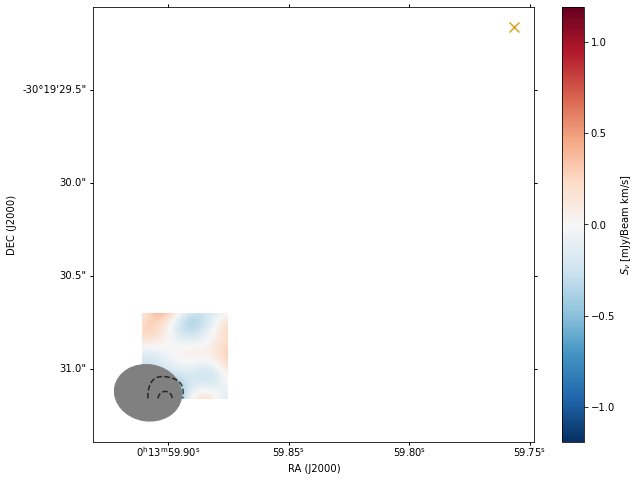

In [15]:
#initilaize
tool = jacked.Jack(vis     = VIS, 
                   spws    = SPWS, 
                   fields  = FIELDS, 
                   band    = BAND,
                   array   = ARRAY,
                   samples = N
                   )

#run
tool.run()

#show
fits_file = tool.vis_jacked.replace('.ms','.im.fits')
plot_fits_image_with_wcs(fits_file, 4, (3.498985, -30.324767),  (index-5, index+5))  # Replace with your FITS file path, desired box size in arcseconds, and center coordinates (RA, DEC)

In [22]:
direc = './output/C7/model/'
fits_files = os.listdir(direc)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


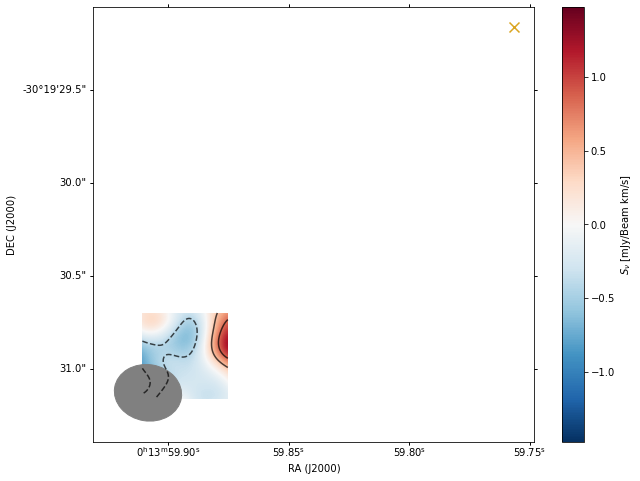

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


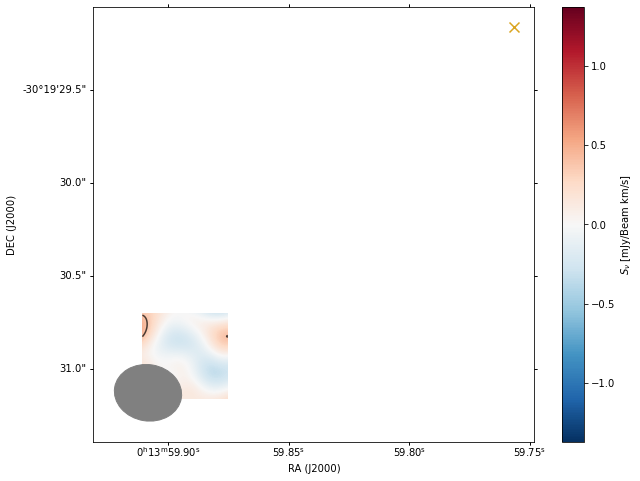

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


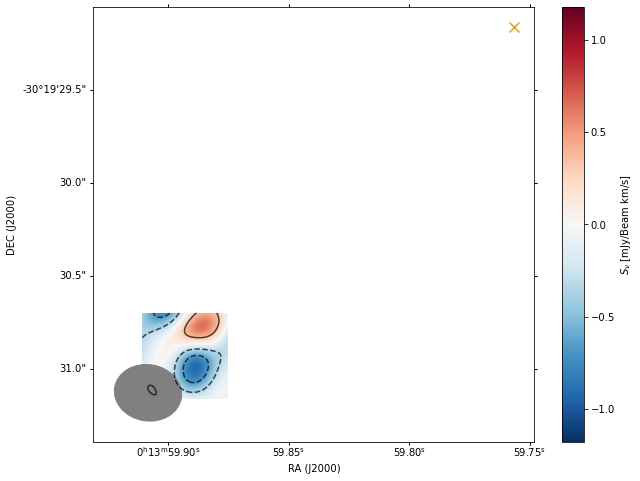

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


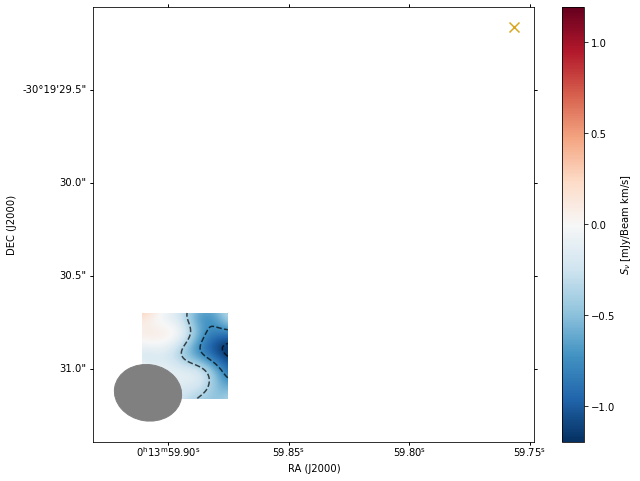

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


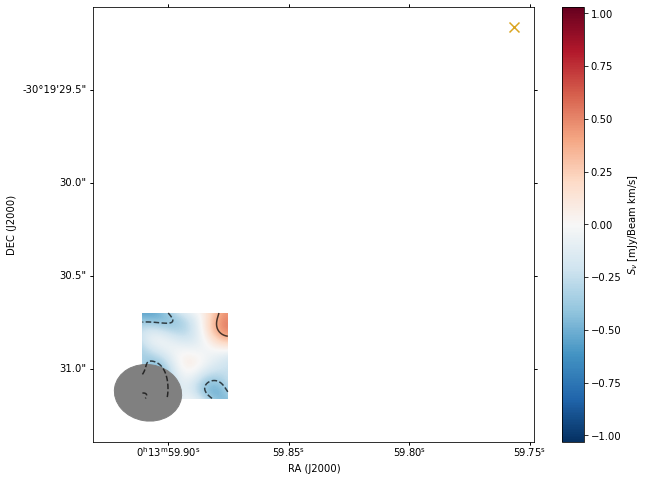

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


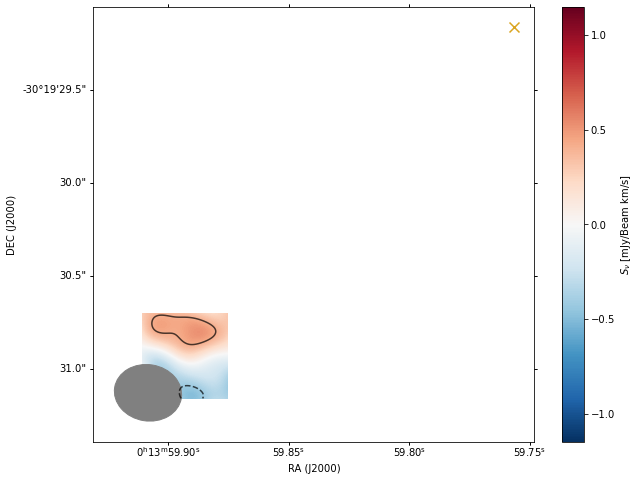

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


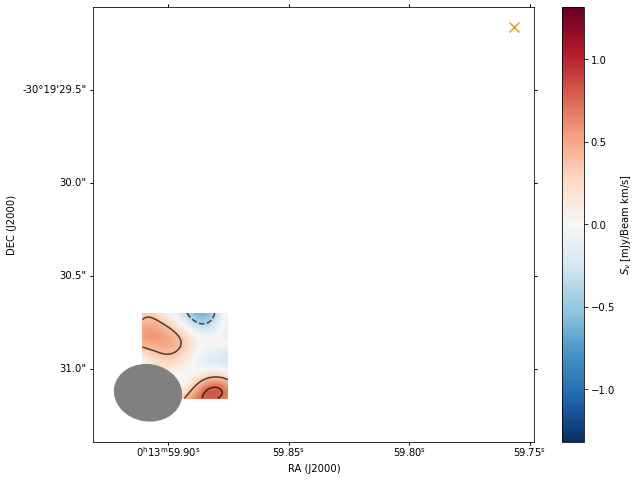

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


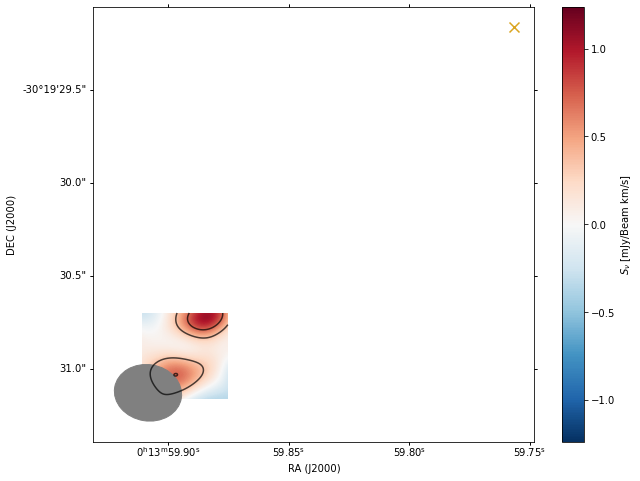

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


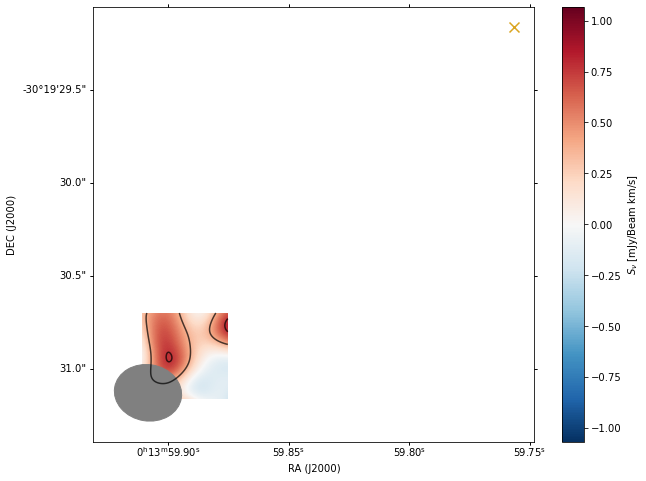

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


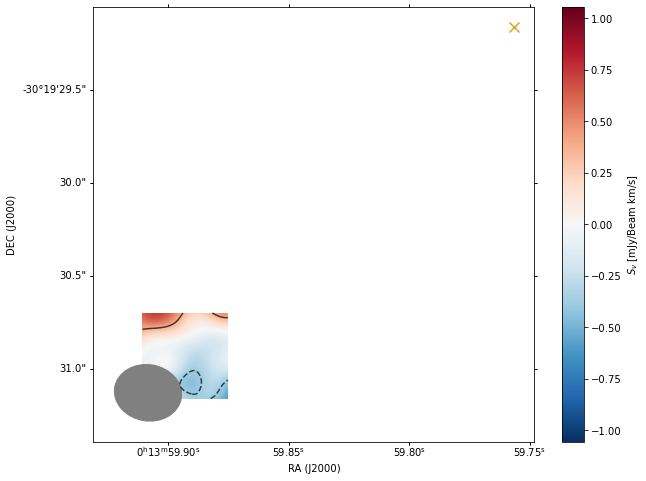

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


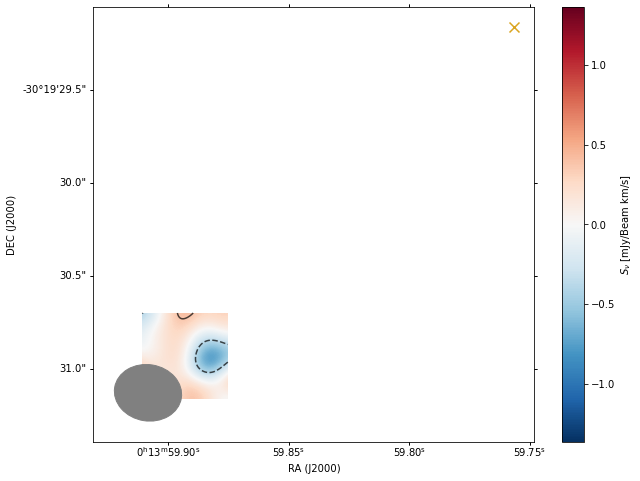

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


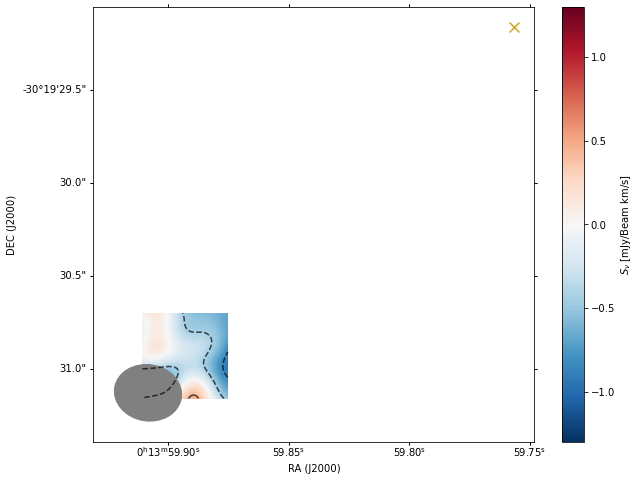

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


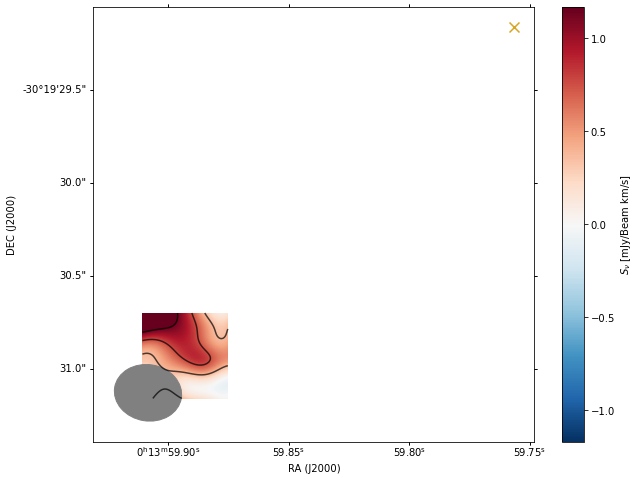

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


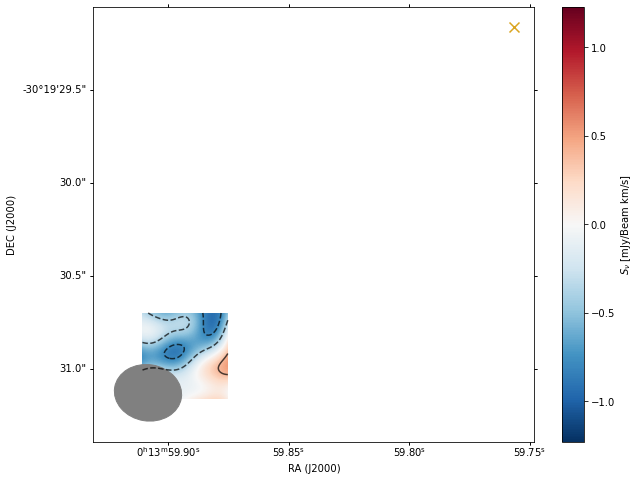

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


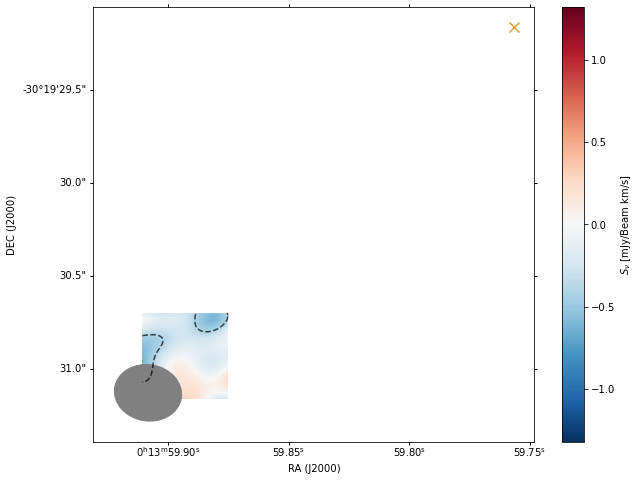

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


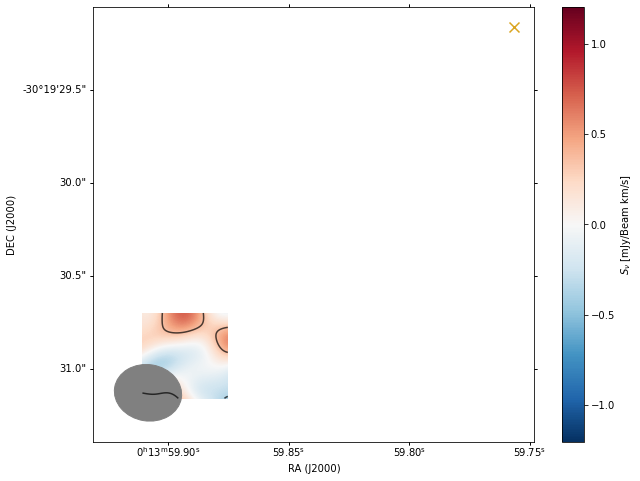

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


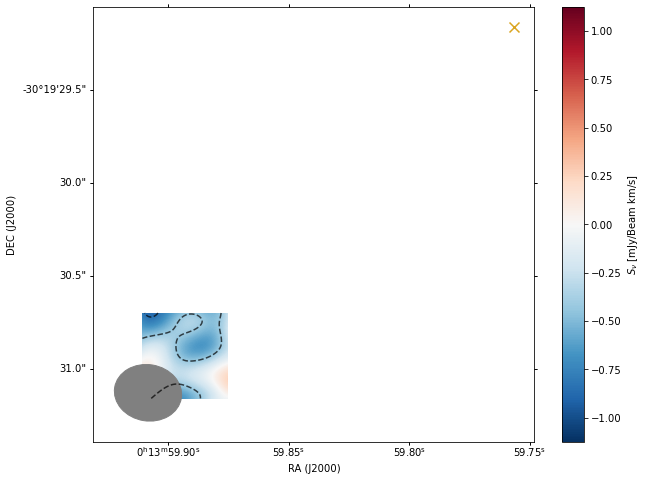

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


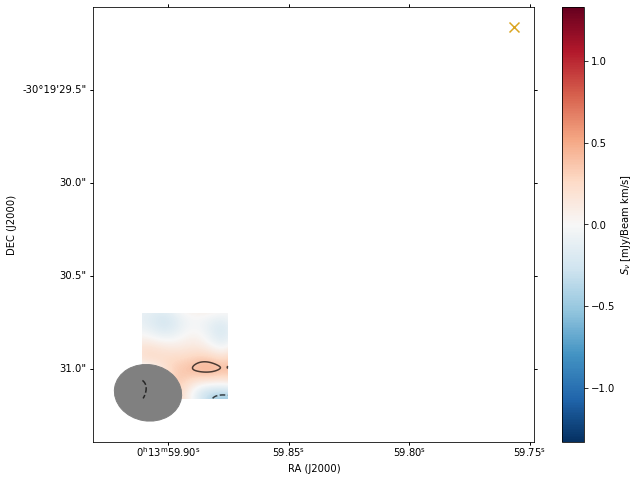

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


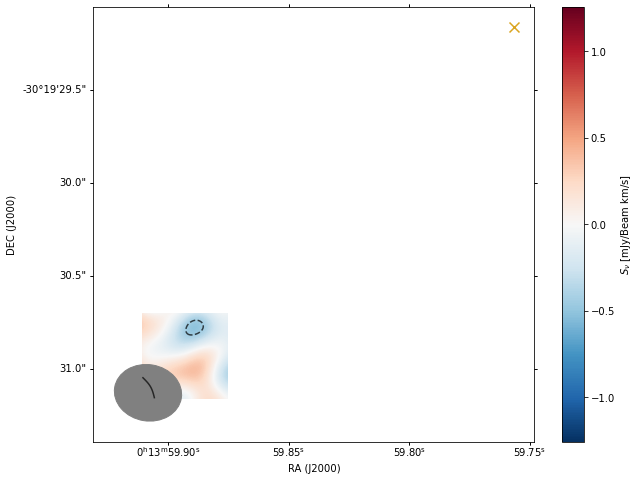

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


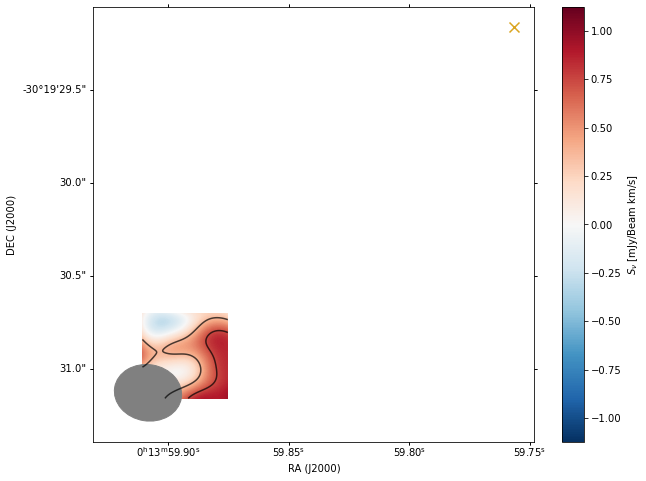

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


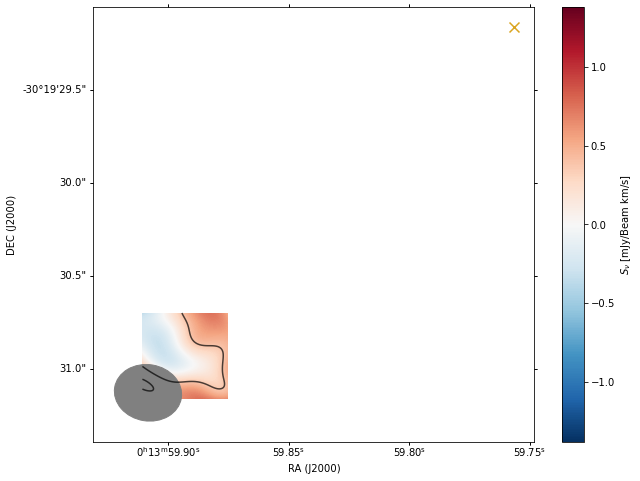

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


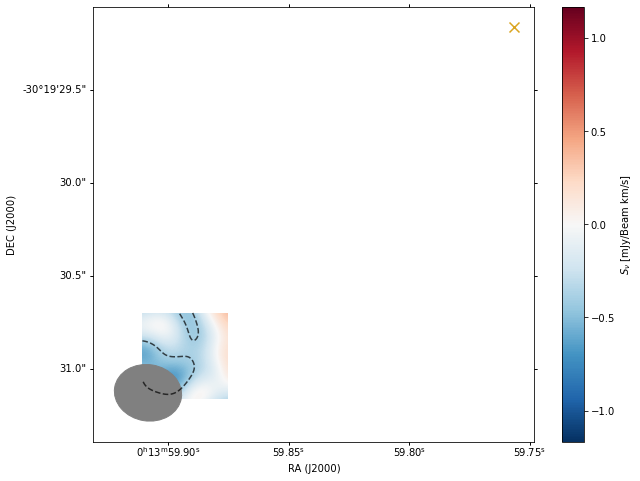

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


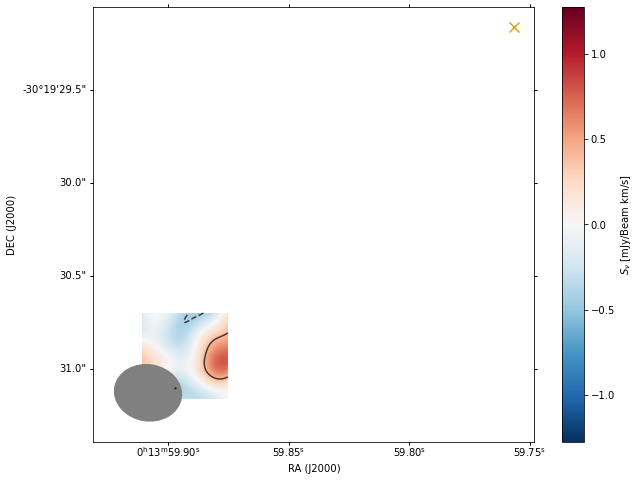

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


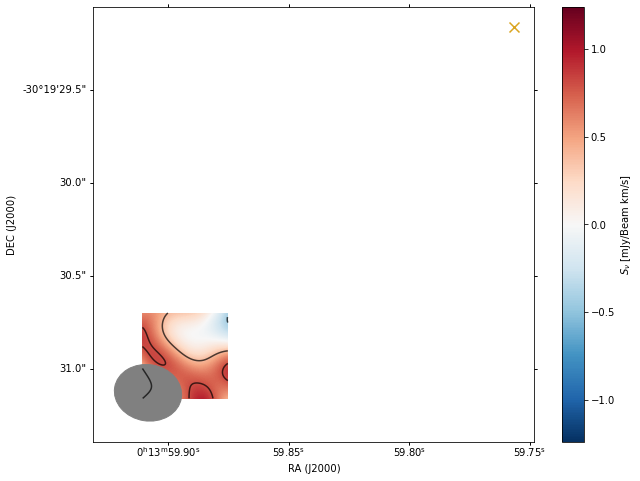

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


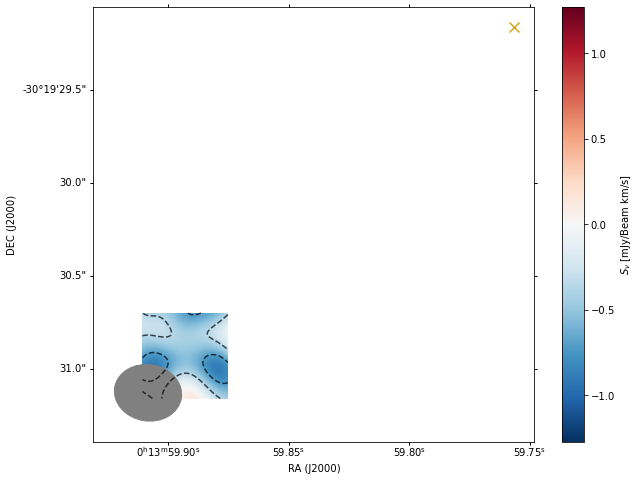

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


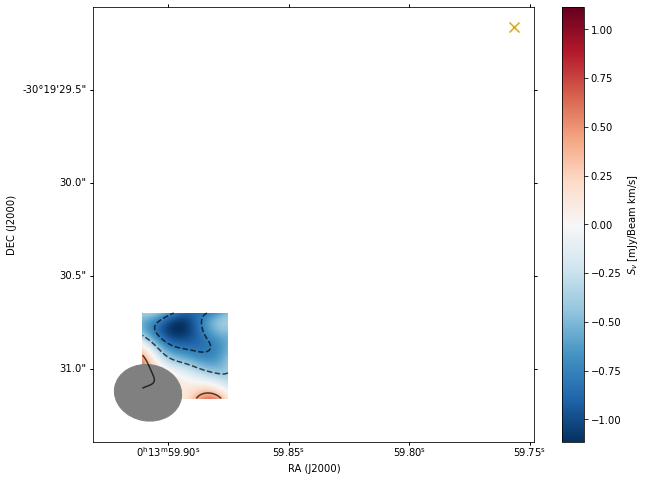

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.

KeyboardInterrupt



In [30]:
for f in fits_files:
    if f.endswith('.fits'):
        plot_fits_image_with_wcs(direc+f, 4, (3.498985, -30.324767),  (index-5, index+5))  # Replace with your FITS file path, desired box size in arcseconds, and center coordinates (RA, DEC)